In [ ]:
!pip install snntorch -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 54.5 MB/s eta 0:00:00


In [ ]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

### Recurrent SNN

In [ ]:
lif1 = snn.Leaky(beta=0.9)

In [ ]:
batch_size = 128
data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Data transforms

In [ ]:
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17291562.25it/s]


Extracting /tmp/data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 473334.22it/s]


Extracting /tmp/data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4264464.72it/s]


Extracting /tmp/data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3228356.00it/s]

Extracting /tmp/data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/data/mnist/MNIST/raw



### Network

In [ ]:
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

num_steps = 25
beta = 0.95

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

net = Net().to(device)

### Accuracy tracing functions

In [ ]:
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

    return acc

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

### Loss and optimizer

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

### Training

In [ ]:
from tqdm import tqdm

In [ ]:
num_epochs = 5
loss_hist = []
test_loss_hist = []
train_acc_hist = []
test_acc_hist = []
counter = 0

for epoch in tqdm(range(num_epochs)):
    iter_counter = 0
    train_batch = iter(train_loader)

    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        loss_hist.append(loss_val.item())

        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            test_spk, test_mem = net(test_data.view(batch_size, -1))

            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            if counter % 50 == 0:
                train_acc = print_batch_accuracy(data, targets, train=True)
                test_acc = print_batch_accuracy(test_data, test_targets, train=False)
                train_acc_hist.append(train_acc)
                test_acc_hist.append(test_acc)
            #     train_printer(
            #         data, targets, epoch,
            #         counter, iter_counter,
            #         loss_hist, test_loss_hist,
            #         test_data, test_targets)
            counter += 1
            iter_counter +=1

  0%|          | 0/5 [00:00<?, ?it/s]

Train set accuracy for a single minibatch: 52.34%
Test set accuracy for a single minibatch: 39.06%
Train set accuracy for a single minibatch: 89.06%
Test set accuracy for a single minibatch: 89.84%
Train set accuracy for a single minibatch: 87.50%
Test set accuracy for a single minibatch: 86.72%
Train set accuracy for a single minibatch: 93.75%
Test set accuracy for a single minibatch: 87.50%
Train set accuracy for a single minibatch: 91.41%
Test set accuracy for a single minibatch: 90.62%
Train set accuracy for a single minibatch: 93.75%
Test set accuracy for a single minibatch: 92.19%
Train set accuracy for a single minibatch: 93.75%
Test set accuracy for a single minibatch: 92.97%
Train set accuracy for a single minibatch: 92.19%
Test set accuracy for a single minibatch: 92.97%
Train set accuracy for a single minibatch: 96.09%
Test set accuracy for a single minibatch: 93.75%
Train set accuracy for a single minibatch: 96.09%
Test set accuracy for a single minibatch: 92.97%


 20%|██        | 1/5 [00:58<03:55, 58.97s/it]

Train set accuracy for a single minibatch: 95.31%
Test set accuracy for a single minibatch: 91.41%
Train set accuracy for a single minibatch: 92.97%
Test set accuracy for a single minibatch: 92.97%
Train set accuracy for a single minibatch: 97.66%
Test set accuracy for a single minibatch: 94.53%
Train set accuracy for a single minibatch: 97.66%
Test set accuracy for a single minibatch: 96.88%
Train set accuracy for a single minibatch: 99.22%
Test set accuracy for a single minibatch: 97.66%
Train set accuracy for a single minibatch: 96.88%
Test set accuracy for a single minibatch: 96.09%
Train set accuracy for a single minibatch: 96.09%
Test set accuracy for a single minibatch: 97.66%
Train set accuracy for a single minibatch: 94.53%
Test set accuracy for a single minibatch: 98.44%
Train set accuracy for a single minibatch: 94.53%
Test set accuracy for a single minibatch: 95.31%


 40%|████      | 2/5 [01:58<02:57, 59.04s/it]

Train set accuracy for a single minibatch: 100.00%
Test set accuracy for a single minibatch: 96.09%
Train set accuracy for a single minibatch: 98.44%
Test set accuracy for a single minibatch: 97.66%
Train set accuracy for a single minibatch: 97.66%
Test set accuracy for a single minibatch: 96.88%
Train set accuracy for a single minibatch: 99.22%
Test set accuracy for a single minibatch: 98.44%
Train set accuracy for a single minibatch: 96.09%
Test set accuracy for a single minibatch: 94.53%
Train set accuracy for a single minibatch: 98.44%
Test set accuracy for a single minibatch: 99.22%
Train set accuracy for a single minibatch: 97.66%
Test set accuracy for a single minibatch: 98.44%
Train set accuracy for a single minibatch: 98.44%
Test set accuracy for a single minibatch: 99.22%
Train set accuracy for a single minibatch: 99.22%
Test set accuracy for a single minibatch: 95.31%
Train set accuracy for a single minibatch: 99.22%
Test set accuracy for a single minibatch: 98.44%


 60%|██████    | 3/5 [02:57<01:58, 59.08s/it]

Train set accuracy for a single minibatch: 98.44%
Test set accuracy for a single minibatch: 98.44%
Train set accuracy for a single minibatch: 99.22%
Test set accuracy for a single minibatch: 93.75%
Train set accuracy for a single minibatch: 97.66%
Test set accuracy for a single minibatch: 97.66%
Train set accuracy for a single minibatch: 98.44%
Test set accuracy for a single minibatch: 96.88%
Train set accuracy for a single minibatch: 97.66%
Test set accuracy for a single minibatch: 97.66%
Train set accuracy for a single minibatch: 98.44%
Test set accuracy for a single minibatch: 98.44%
Train set accuracy for a single minibatch: 95.31%
Test set accuracy for a single minibatch: 93.75%
Train set accuracy for a single minibatch: 98.44%
Test set accuracy for a single minibatch: 95.31%
Train set accuracy for a single minibatch: 96.88%
Test set accuracy for a single minibatch: 99.22%


 80%|████████  | 4/5 [03:56<00:59, 59.19s/it]

Train set accuracy for a single minibatch: 96.09%
Test set accuracy for a single minibatch: 96.09%
Train set accuracy for a single minibatch: 99.22%
Test set accuracy for a single minibatch: 96.88%
Train set accuracy for a single minibatch: 97.66%
Test set accuracy for a single minibatch: 97.66%
Train set accuracy for a single minibatch: 98.44%
Test set accuracy for a single minibatch: 98.44%
Train set accuracy for a single minibatch: 98.44%
Test set accuracy for a single minibatch: 97.66%
Train set accuracy for a single minibatch: 99.22%
Test set accuracy for a single minibatch: 96.09%
Train set accuracy for a single minibatch: 96.88%
Test set accuracy for a single minibatch: 96.09%
Train set accuracy for a single minibatch: 98.44%
Test set accuracy for a single minibatch: 98.44%
Train set accuracy for a single minibatch: 99.22%
Test set accuracy for a single minibatch: 98.44%


100%|██████████| 5/5 [04:54<00:00, 58.96s/it]


If this was your first time training an SNN, then congratulations!

### Results

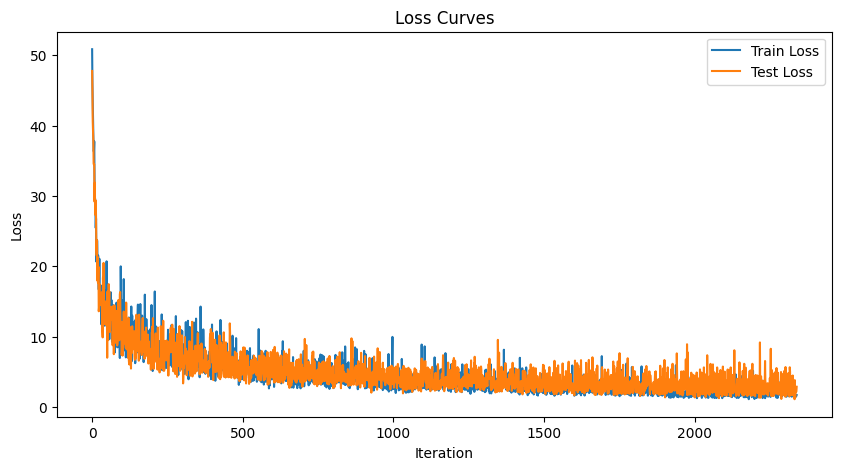

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

The loss curves are noisy because the losses are tracked at every iteration, rather than averaging across multiple iterations.

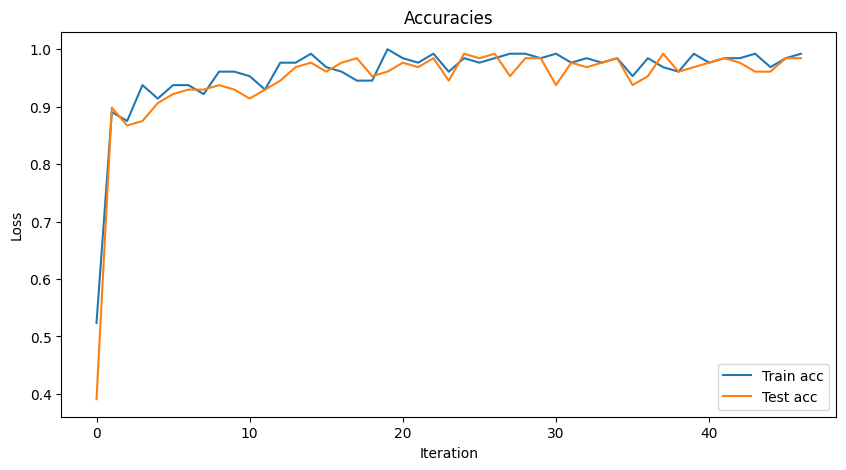

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(train_acc_hist)
plt.plot(test_acc_hist)
plt.title("Accuracies")
plt.legend(["Train acc", "Test acc"], loc='lower right')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()